In [93]:
%matplotlib widget

In [94]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
import empymod 
from scipy.constants import mu_0
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D

In [95]:
def DualEM_842s(sigmas, thicks, coil_orient=np.array(['H', 'P', 'V']), height=0.15):
    """ Here we compute DualEM 842s data using the function `empymod.dipole` function
    for a 1D earth resistivity model
    
    We model the impedance ratio (Z) between the primary (H_p) and secondary (H_s) magnetic fields
    
    The data computed is returned in Quadrature or Out-of-Phase (OP) and In-Phase (IP) components 
    for each coil orientation and coil-coil separation:
    
    H : Horizontal Coplanar -> 2 m, 4 m 8 m coil-coil separation
    V : Vertical Coplanar   -> 2 m, 4 m 8 m coil-coil separation
    P : Perpendicular       -> 2.1 m, 4.1 m 8.1 m coil-coil separation
    Using a Frequency of 9000 Hz
    
    Parameters
    ----------
    sigmas : ndarray
        Logarithm of electrical conductivity values of each layer of the model
        
    thicks : ndarray
        Thicknesses of each layer of the model
        
    coil_orient : array of str, e.g.: np.array(['H', 'V', 'P'])
        coil orientations: 'H' for horizontal coplanar, 'V' for vertical coplanar, 'P' for perpendicular
    
    height : float
        height of the device with respect to ground surface [m]
    
    Returns
    -------
    DualEM : ndarray
        DualEM response [OP, IP] for each coil orientation and each coil offset [ppt]
        in parts per thousand
        
        shape: [nr of coil orientations, 2, nr of coil offsets]  
    """
    
  #  if len(depth) != len(res):
  #      raise TypeError('depth and res arrays should have the same length!')
    
    # Define DualEM 842s parameters
    
    Freq = 9000
    coil_spacing = [2, 4, 8]
    coil_spacing_p = [2.1, 4.1, 8.2]
    
    res_air = 1e6 # air resistivity
    
    sigmas = np.array(sigmas)
    res = np.hstack(([res_air], 1/sigmas))
    
   # print('res: ', res)
    
    depth = np.hstack(([0],-np.cumsum(thicks)))
    
   # print('depth:', depth)
    
    # Define source and receivers geometry
    
    source = [0, 0, -height]
    receivers = [coil_spacing, np.zeros_like(coil_spacing), -height]
    receivers_p = [coil_spacing_p, np.zeros_like(coil_spacing_p), -height]
    
    # Define resistivity model
    #res = np.hstack((res_air, res)) # include air resistivity
    
    # Empty array to store store responses
    OUT = []
    
    # Calculate for horizontal coil orientation
    if any(coil_orient == 'H'):
        # Secondary magnetic field
        H_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 66, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        H_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq,
                              ab = 66, verb=0)*(2j * np.pi * Freq * mu_0)   
        op = (H_Hs/H_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (H_Hs/H_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for vertical coil orientation
    if any(coil_orient == 'V'):
        # Secondary magnetic field
        V_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 55, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        # Primary magnetic field
        V_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime = Freq, ab = 55, 
                              verb=0)*(2j * np.pi * Freq * mu_0)
        op = (V_Hs/V_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (V_Hs/V_Hp).real.amp() * 1e3 # In Phase
        OUT.append([op, ip])

    # Calculate for perpendicular coil orientation
    if any(coil_orient == 'P'):
        P_Hs = empymod.dipole(source, receivers, depth, res, Freq, ab = 46, xdirect = None, 
                              verb=0)*(2j * np.pi * Freq * mu_0) 
        P_Hp = empymod.dipole(source, receivers, depth=[], res=[res_air], freqtime= Freq,
                              ab = 66, verb = 0)*(2j * np.pi * Freq * mu_0) 
        op = (P_Hs/P_Hp).imag.amp() * 1e3 # Out of Phase
        ip = (P_Hs/P_Hp).real.amp() * 1e3 # In Phase

        OUT.append([op, ip])

    return np.array(OUT).ravel() # [HOP, HIP, VOP, VIP, POP, PIP]

In [96]:
class FDEM_1D(pg.frameworks.Modelling):
    """ Class to Initialize the model for Gauss-Newton inversion
    using the quadrature (Q) and in-phase (IP) components of the measurements
    for a n-layered model
    
    Input:

        nlay : number of layers
    """   
    def __init__(self, nlay=3):
        self.nlay = nlay
        mesh = pg.meshtools.createMesh1DBlock(nlay)
        super().__init__()
        self.setMesh(mesh)

    
    def response(self, par):
        """ Compute response vector for a certain model [mod] 
        par = [thickness_1, thickness_2, ..., thickness_n, sigma_1, sigma_2, ..., sigma_n]
        """
        print('model:', par)  
        resp = DualEM_842s(sigmas = par[self.nlay-1:],
                           thicks = par[:self.nlay-1]
                              )
        return resp
    
    def response_mt(self, par, i=0):
        """Multi-threaded forward response."""
        return self.response(par)
    
#    def createJacobian(self, par, factor=1.05): #CHANGE
#        """ compute Jacobian for a 1D model """
#        resp = self.response(par)
#        n_rows = len(resp) # number of data values in data vector
#        n_cols = len(par) # number of model parameters
#        J = self.jacobian() # we define first this as the jacobian
#        J.resize(n_rows, n_cols)
#        Jt = np.zeros((n_cols, n_rows))
        
#        modTrans = self.modelTrans(par)
        
#        for j in range(n_cols):
#    #        mod_plus_dx = par.copy()
#            mod_plus_dx = modTrans.copy()
#            mod_plus_dx[j] *= factor
            
#            mod_plus_dx_invTrans = self.modelTrans.invTrans(mod_plus_dx)
#            Jt[j,:] = (self.response(mod_plus_dx_invTrans) - resp)/factor # J.T in col j
#        for i in range(n_rows):
#            J[i] = Jt[:,i]
            
        return J
        #print(self.jacobian())
        #print(J)
        #print(Jt)
        
    def drawModel(self, ax, model):
        pg.viewer.mpl.drawModel1D(ax = ax,
                                  model = model,
                                  plot = 'semilogx',
                                  xlabel = 'Electrical conductivity (S/m)',
                                  )
        ax.set_ylabel('Depth in (m)')

In [97]:
# Calculate resolution matrix

def scaledJacobianMatrix(inv):
    """Return error-weighted transformation-scaled Jacobian.

    Parameters
    ----------
    inv : pg.Inversion (pygimli.framework.Inversion)

    Returns
    -------
    DJ : numpy full matrix
    """
    J = inv.fop.jacobian()  # sensitivity matrix
    d = 1. / inv.dataTrans.error(inv.response, inv.errorVals)
    left = np.reshape(inv.dataTrans.deriv(inv.response) / d, [-1, 1])
    right = np.reshape(1 / inv.modelTrans.deriv(inv.model), [1, -1])
    if isinstance(J, pg.Matrix):  # e.g. ERT
        return left * pg.utils.gmat2numpy(J) * right
    elif isinstance(J, pg.SparseMapMatrix):  # e.g. Traveltime
        return left * pg.utils.sparseMat2Numpy.sparseMatrix2Dense(J) * right
    else:
        raise TypeError("Matrix type cannot be converted")
        
        
def modelResolutionMatrix(inv):
    """Formal model resolution matrix (MRM) from inversion.

    Parameters
    ----------
    inv : pg.Inversion (pygimli.framework.Inversion)

    Returns
    -------
    MR : pg.Matrix (pg.matrix.core.RMatrix dense matrix)
    """

    J = np.array(inv.fop.jacobian())
    JTJ = J.T.dot(J)
    
    return np.linalg.inv(JTJ).dot(JTJ)

In [134]:
# Inversion for 2 Layers

FOP = FDEM_1D(nlay = 2)

sigmas = [20/1000, 100/1000]
thicks = [2]

model_true = thicks+sigmas

data = FOP.response(model_true)

transThk = pg.trans.TransLogLU(0.1,4)
transSig = pg.trans.TransLogLU(1/1000,1000/1000)

FOP.region(0).setTransModel(transThk)
FOP.region(1).setTransModel(transSig)

inv = pg.Inversion()
inv.setForwardOperator(FOP)
J = inv.fop.jacobian()

#J = FOP.createJacobian(model_true)

rel_err = np.ones_like(data)*1e-2
model_inv = inv.run(data, rel_err, verbose=True, startModel=[3, 100/1000, 100/1000], lam=0, )

J

14/02/25 - 14:13:54 - pyGIMLi - INFO - Starting inversion.


model: [2, 0.02, 0.1]
min/max(dweight) = 1.48978/1577.43
fop: <__main__.FDEM_1D object at 0x7fa7f2493f60>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fa7efce3060>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7fa7efd6a110>
	 1 <pgcore._pygimli_.RTransLogLU object at 0x7fa7efd88180>
min/max (data): 0.06/67.12
min/max (error): 1%/1%
min/max (start model): 0.1/3
--------------------------------------------------------------------------------
model: 3 [3.0, 0.1, 0.1]
use model trans from RegionManager
model: 3 [3.0, 0.1, 0.1]
min/max(dweight) = 1.48978/1577.43
Building constraints matrix
constraint matrix of size(nBounds x nModel) 1 x 3
check Jacobian: wrong dimensions: (0x0) should be (18x3)  force: 1
jacobian size invalid, forced recalc: 1
model: 3 [3.1500000000000004, 0.1, 0.1]
model: 3 [3.0, 0.10500000000000001, 0.1]
model: 3 [3.0, 0.1, 0.10500000000000001]
inv.iter 0 ... chi² = 460389.15
------------------------------------------------

RMatrix: 18 x 3

7: Model: min = 0.0199993; max = 1.99993
7: Response: min = 0.0633953; max = 67.1249
7: rms/rrms(data, Response) = 0.000574188/0.0111827%
7: chi^2(data, Response, error, log) = 0.000125053
7: Phi = 0.00225096+3.01326*0=0.00225096


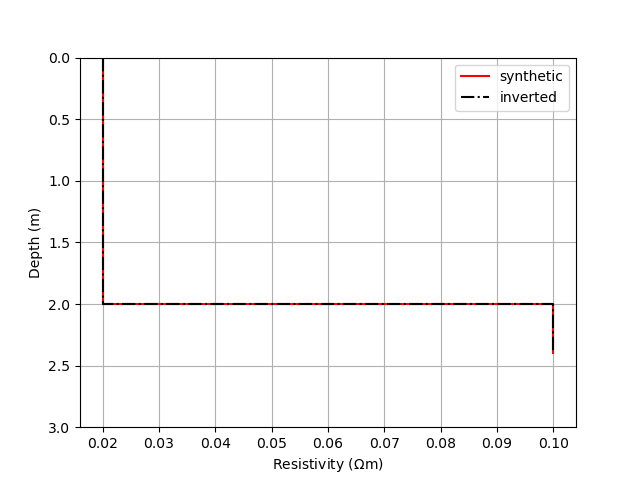

In [135]:
fig, ax = plt.subplots()
drawModel1D(ax, model = model_true, label="synthetic", c='r')
drawModel1D(ax, model = model_inv, label="inverted", c='k', linestyle='-.')
ax.grid(which='minor')
ax.set_ylim([0,3])
ax.invert_yaxis()
_ = ax.legend()

In [136]:
model_true

[2, 0.02, 0.1]

In [137]:
model_inv

3 [1.99992792343789, 0.019999322937612907, 0.09999993516215684]

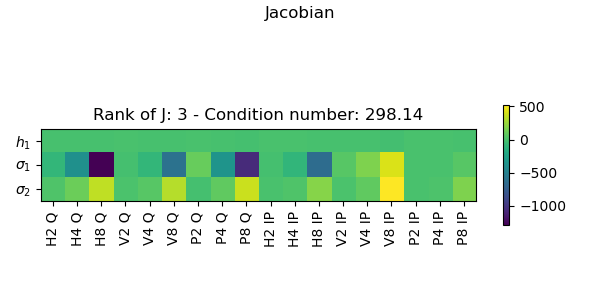

In [138]:
fig, ax = plt.subplots(figsize=(6,3))

c = ax.imshow(np.array(J).T)

fig.colorbar(c, shrink=0.5)

xticks = ['H2 Q', 'H4 Q', 'H8 Q', 'V2 Q', 'V4 Q', 'V8 Q', 'P2 Q', 'P4 Q', 'P8 Q',
          'H2 IP', 'H4 IP', 'H8 IP', 'V2 IP', 'V4 IP', 'V8 IP', 'P2 IP', 'P4 IP', 'P8 IP' ]

yticks = ['$h_1$', '$\sigma_1$', '$\sigma_2$',  ]

ax.set_xticks(range(len(data)), labels=xticks, rotation = 90)
ax.set_yticks(range(len(model_true)), labels=yticks)

ax.set_title('Rank of J: ' + str( np.linalg.matrix_rank(J)) +' - Condition number: %.2f' %np.linalg.cond(J) )

fig.suptitle('Jacobian')

plt.tight_layout()

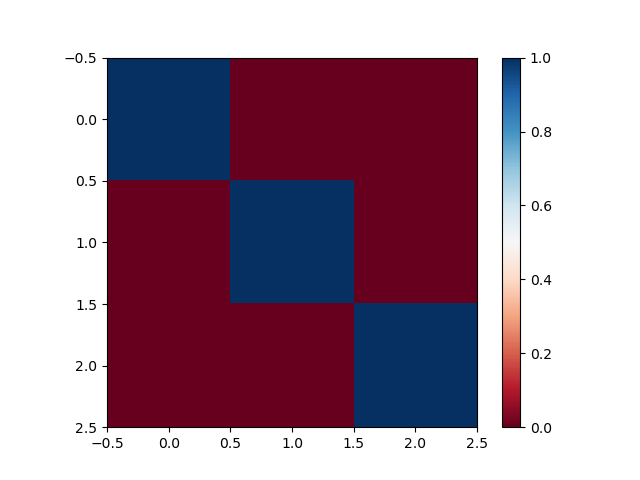

In [139]:
R = modelResolutionMatrix(inv)

fig, ax = plt.subplots()

c = ax.imshow(R, cmap='RdBu')

fig.colorbar(c)



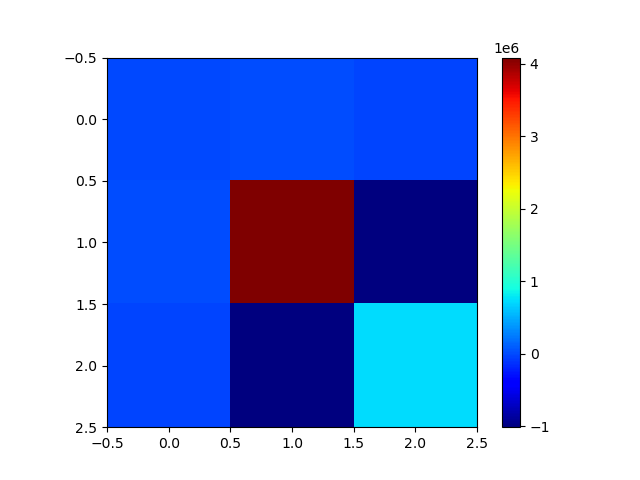

In [140]:
J = np.array(J)

JTJ = J.T.dot(J)

fig, ax = plt.subplots()
c = ax.imshow(JTJ, cmap='jet')
fig.colorbar(c)

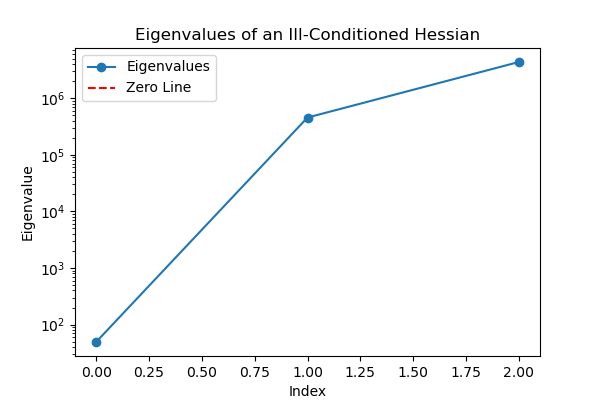

Condition Number: 8.89e+04


In [141]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(JTJ)  # More stable for symmetric matrices

# Plot eigenvalues
plt.figure(figsize=(6, 4))
plt.semilogy(eigenvalues, 'o-', label="Eigenvalues")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of an Ill-Conditioned Hessian")
plt.legend()
plt.show()

# Print condition number
condition_number = np.max(eigenvalues) / np.min(eigenvalues)
print(f"Condition Number: {condition_number:.2e}")

In [142]:
eigenvalues

array([4.91483759e+01, 4.55777444e+05, 4.36879180e+06])

In [143]:
# Inversion for 3 Layers

FOP = FDEM_1D(nlay = 3)

sigmas = [20/1000, 150/1000, 30/1000]
thicks = [2, 3]

model_true = thicks+sigmas

data = FOP.response(model_true)

transThk = pg.trans.TransLogLU(0.1,4)
transSig = pg.trans.TransLogLU(10/1000, 200/1000)

FOP.region(0).setTransModel(transThk)
FOP.region(1).setTransModel(transSig)

inv = pg.Inversion()
inv.setForwardOperator(FOP)

rel_err = np.ones_like(data)*1e-2
model_inv = inv.run(data, rel_err, verbose=False, startModel=[1, 1, 100/1000, 100/1000, 100/1000], lam=0, )

model: [2, 3, 0.02, 0.15, 0.03]
model: 5 [1.0, 1.0, 0.1, 0.1, 0.1]
model: 5 [1.0, 1.0, 0.1, 0.1, 0.1]
model: 5 [1.05, 1.0, 0.1, 0.1, 0.1]
model: 5 [1.0, 1.05, 0.1, 0.1, 0.1]
model: 5 [1.0, 1.0, 0.10500000000000001, 0.1, 0.1]
model: 5 [1.0, 1.0, 0.1, 0.10500000000000001, 0.1]
model: 5 [1.0, 1.0, 0.1, 0.1, 0.10500000000000001]
model: 5 [1.0, 1.0, 0.0521024109031754, 0.14771009875198848, 0.11175106093227659]
model: 5 [1.0, 1.0, 0.0521024109031754, 0.14771009875198848, 0.11175106093227659]
model: 5 [1.05, 1.0, 0.0521024109031754, 0.14771009875198848, 0.11175106093227659]
model: 5 [1.0, 1.05, 0.0521024109031754, 0.14771009875198848, 0.11175106093227659]
model: 5 [1.0, 1.0, 0.05470753144833417, 0.14771009875198848, 0.11175106093227659]
model: 5 [1.0, 1.0, 0.0521024109031754, 0.1550956036895879, 0.11175106093227659]
model: 5 [1.0, 1.0, 0.0521024109031754, 0.14771009875198848, 0.11733861397889042]
model: 5 [1.920666209155504, 1.1491853072523277, 0.034503077985714045, 0.19247654594820382, 0.069

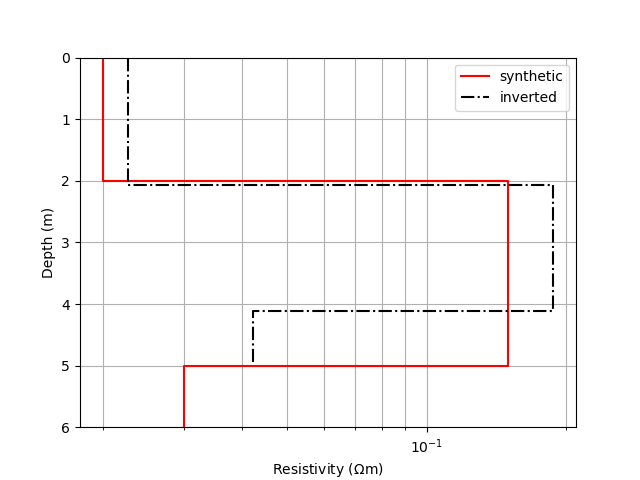

In [144]:
fig, ax = plt.subplots()
drawModel1D(ax, model=model_true, label="synthetic", c='r')
drawModel1D(ax, model = model_inv, plot="semilogx", label="inverted", c='k', linestyle='-.')
ax.grid(which='minor')
ax.set_ylim([0,6])
ax.invert_yaxis()
_ = ax.legend()

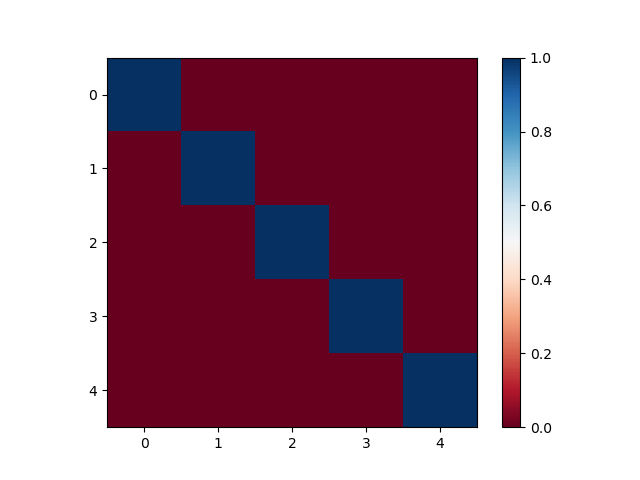

In [145]:
R = modelResolutionMatrix(inv)

fig, ax = plt.subplots()

c = ax.imshow(R, cmap='RdBu')

fig.colorbar(c)

In [146]:
J = np.array(FOP.createJacobian(thicks + sigmas))

JTJ = J.T.dot(J)

fig, ax = plt.subplots()
c = ax.imshow(JTJ, cmap='jet')
fig.colorbar(c)

model: 5 [2.0, 3.0, 0.02, 0.15, 0.03]
model: 5 [2.1, 3.0, 0.02, 0.15, 0.03]
model: 5 [2.0, 3.1500000000000004, 0.02, 0.15, 0.03]
model: 5 [2.0, 3.0, 0.021, 0.15, 0.03]
model: 5 [2.0, 3.0, 0.02, 0.1575, 0.03]
model: 5 [2.0, 3.0, 0.02, 0.15, 0.0315]


TypeError: unsupported operand type(s) for *: 'NoneType' and 'NoneType'

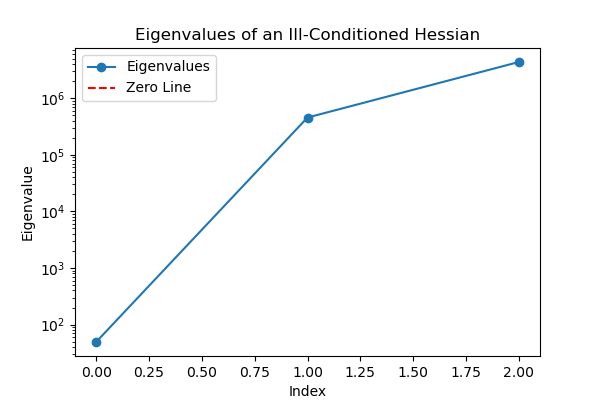

Condition Number: 8.89e+04


In [147]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(JTJ)  # More stable for symmetric matrices

# Plot eigenvalues
plt.figure(figsize=(6, 4))
plt.semilogy(eigenvalues, 'o-', label="Eigenvalues")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of an Ill-Conditioned Hessian")
plt.legend()
plt.show()

# Print condition number
condition_number = np.max(eigenvalues) / np.min(eigenvalues)
print(f"Condition Number: {condition_number:.2e}")

In [122]:
eigenvalues

array([2.91413872e-01, 1.32685776e+01, 2.28072401e+02, 1.44784794e+03,
       1.14023580e+04])

In [123]:
# Inversion for 4 Layers

FOP = FDEM_1D(nlay = 4)

sigmas = [20/1000, 150/1000, 30/1000, 50/1000]
thicks = [2, 3, 1]

model_true = thicks+sigmas

data = FOP.response(model_true)

transThk = pg.trans.TransLogLU(0.1,4)
transSig = pg.trans.TransLogLU(10/1000, 200/1000)

FOP.region(0).setTransModel(transThk)
FOP.region(1).setTransModel(transSig)

inv = pg.Inversion()
inv.setForwardOperator(FOP)

rel_err = np.ones_like(data)*1e-2
model_inv = inv.run(data, rel_err, verbose=False, startModel=[1, 1, 1, 100/1000, 100/1000, 100/1000, 100/1000], lam=0, )

model: [2, 3, 1, 0.02, 0.15, 0.03, 0.05]
model: 7 [1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.1]
model: 7 [1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.1]
model: 7 [1.01, 1.0, 1.0, 0.1, 0.1, 0.1, 0.1]
model: 7 [1.0, 1.01, 1.0, 0.1, 0.1, 0.1, 0.1]
model: 7 [1.0, 1.0, 1.01, 0.1, 0.1, 0.1, 0.1]
model: 7 [1.0, 1.0, 1.0, 0.101, 0.1, 0.1, 0.1]
model: 7 [1.0, 1.0, 1.0, 0.1, 0.101, 0.1, 0.1]
model: 7 [1.0, 1.0, 1.0, 0.1, 0.1, 0.101, 0.1]
model: 7 [1.0, 1.0, 1.0, 0.1, 0.1, 0.1, 0.101]
model: 7 [1.0, 1.0, 1.0, 0.010000220492376513, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.0, 1.0, 1.0, 0.010000220492376513, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.01, 1.0, 1.0, 0.010000220492376513, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.0, 1.01, 1.0, 0.010000220492376513, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.0, 1.0, 1.01, 0.010000220492376513, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.0, 1.0, 1.0, 0.010100222697300279, 0.2, 0.01, 0.10566673454839445]
model: 7 [1.0, 1.0, 1.0, 0.010000220492376513, 0.202, 0.01, 0.1056

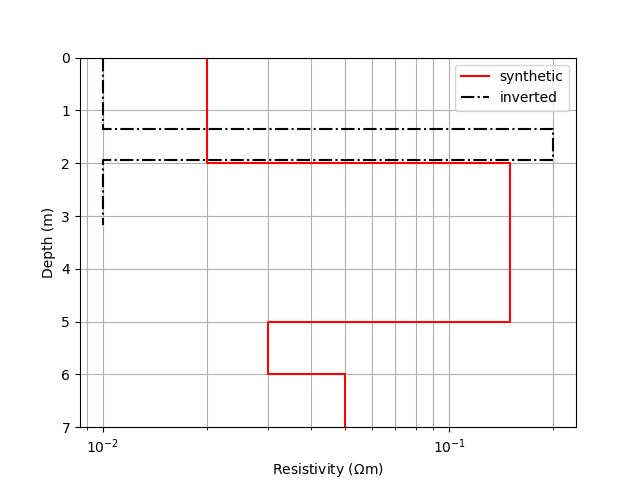

In [124]:
fig, ax = plt.subplots()
drawModel1D(ax, model=model_true, label="synthetic", c='r')
drawModel1D(ax, model = model_inv, plot="semilogx", label="inverted", c='k', linestyle='-.')
ax.grid(which='minor')
ax.set_ylim([0,7])
ax.invert_yaxis()
_ = ax.legend()

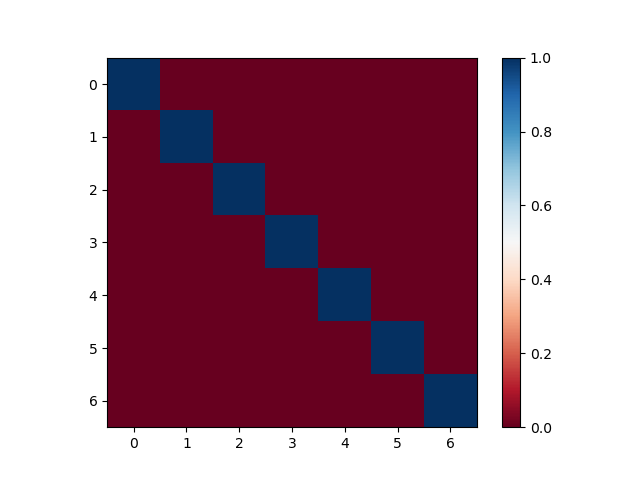

In [125]:
R = modelResolutionMatrix(inv)

fig, ax = plt.subplots()

c = ax.imshow(R, cmap='RdBu')

fig.colorbar(c)

model: [2, 3, 1, 0.02, 0.15, 0.03, 0.05]
model: [2.02, 3, 1, 0.02, 0.15, 0.03, 0.05]
model: [2, 3.0300000000000002, 1, 0.02, 0.15, 0.03, 0.05]
model: [2, 3, 1.01, 0.02, 0.15, 0.03, 0.05]
model: [2, 3, 1, 0.0202, 0.15, 0.03, 0.05]
model: [2, 3, 1, 0.02, 0.1515, 0.03, 0.05]
model: [2, 3, 1, 0.02, 0.15, 0.0303, 0.05]
model: [2, 3, 1, 0.02, 0.15, 0.03, 0.0505]


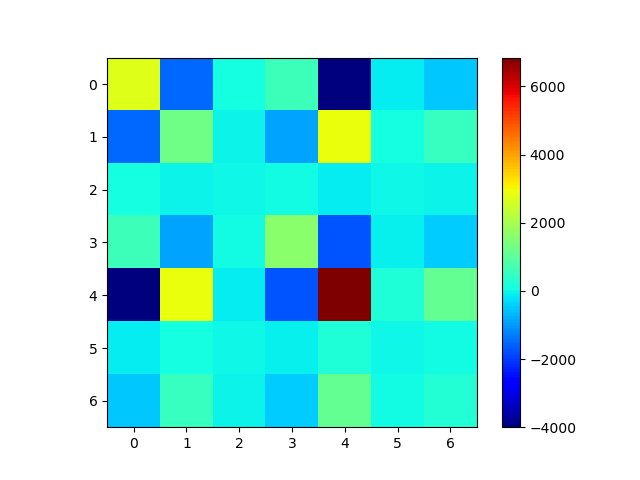

In [126]:
J = np.array(FOP.createJacobian(thicks + sigmas))

JTJ = J.T.dot(J)

fig, ax = plt.subplots()
c = ax.imshow(JTJ, cmap='jet')
fig.colorbar(c)

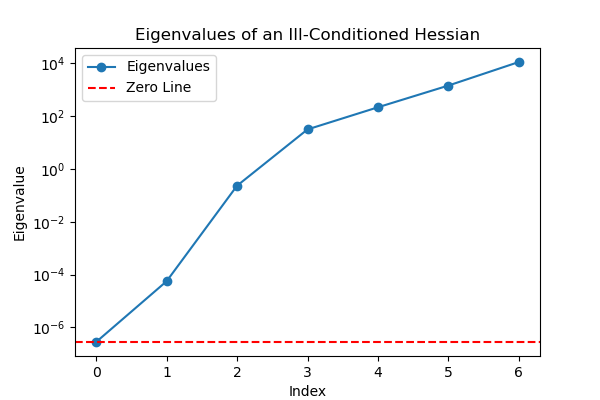

Condition Number: 3.95e+10


In [127]:
# Compute eigenvalues
eigenvalues = np.linalg.eigvalsh(JTJ)  # More stable for symmetric matrices

# Plot eigenvalues
plt.figure(figsize=(6, 4))
plt.semilogy(eigenvalues, 'o-', label="Eigenvalues")
plt.axhline(y=np.min(eigenvalues), color='r', linestyle='--', label="Zero Line")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of an Ill-Conditioned Hessian")
plt.legend()
plt.show()

# Print condition number
condition_number = np.max(eigenvalues) / np.min(eigenvalues)
print(f"Condition Number: {condition_number:.2e}")

In [128]:
eigenvalues

array([2.80341916e-07, 5.57611733e-05, 2.29835682e-01, 3.10814977e+01,
       2.14126559e+02, 1.42234938e+03, 1.10619232e+04])